In [1]:
import pickle
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_inline.backend_inline import set_matplotlib_formats
from nltk import sent_tokenize, word_tokenize
from nltk.collocations import (BigramCollocationFinder,
                               QuadgramCollocationFinder,
                               TrigramCollocationFinder)
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             silhouette_score)
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
sns.set_style("whitegrid")
set_matplotlib_formats("svg")

## Cleaning

In [3]:
def load_anthems_data(path="./data/data.pickle", 
                      punctuation_to_keep=",.:;?!'-", 
                      lyrics_lowercase=False, 
                      countries_lowercase=False, 
                      clean_countries=False, # remove additional text in parantheses (e.g years) 
                      keep_countries_without_lyrics=True,
                      keep_countries_with_invalid_iso2=False,
                      add_iso3_codes=True):
                        
    with open(path, "rb") as handle:
        data = pickle.load(handle)

    _df = pd.DataFrame.from_dict(data, orient="index", columns=["iso_2", "lyrics"])
    countries_iso_2 = [country.alpha_2 for country in list(pycountry.countries)]
    countries_iso_3 = [country.alpha_3 for country in list(pycountry.countries)]

    if not keep_countries_with_invalid_iso2:
        df = _df.loc[_df["iso_2"].isin(countries_iso_2)].copy()  # Create a copy of the DataFrame slice
    else: df = _df.copy()

    if add_iso3_codes:
        if keep_countries_with_invalid_iso2:
            raise ValueError("Cannot add iso3 codes when `keep_countries_with_invalid_iso2` is set to `True`")
        df["iso_a3"] = np.array(countries_iso_3)[[countries_iso_2.index(i) for i in df["iso_2"].values]]
        df.loc["Kosovo", :] = _df.loc["Kosovo"].to_list() + ["-99"]
        df.loc["Somaliland", :] = _df.loc["Somaliland"].to_list() + ["SOL"]
        columns = ["iso_2", "iso_a3", "lyrics"]
    else: columns = ["iso_2", "lyrics"]

    punctuation_pattern = "[^\\w\\d" + "\\".join(list(punctuation_to_keep)) + "\\s]+" 
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"[0-9][\.]?", "", text)) # remove numbers and numbers with dot
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"chorus", "", text, flags=re.IGNORECASE)) # remove CHORUS strings
    df["lyrics"] = df["lyrics"].apply(lambda text: text.replace("\r", " ").replace("\n", " ")) # remove newline characters
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r" {2,}", " ", text)) # remove double spaces
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(punctuation_pattern, "", text)) # remove selected punctuation
    df["lyrics"] = df["lyrics"].apply(lambda text: text.strip()) # remove trailing spaces
    if lyrics_lowercase:
        df["lyrics"] = df["lyrics"].apply(lambda text: text.lower())
    if countries_lowercase:
        df.index = df.index.str.lower()
    if clean_countries: # remove additional text in parantheses (e.g years)
        df.index = df.index.map(lambda name: re.sub(r"(\(.*\))|(\[.*\])", '', name).strip())
    if not keep_countries_without_lyrics:
        df = df[df["lyrics"] != ""]

    return df[columns].sort_index(inplace=False)

In [4]:
df = load_anthems_data(
    punctuation_to_keep="'", 
    lyrics_lowercase=True, 
    countries_lowercase=True, 
    clean_countries=True)
df

iso_2 iso_a3  \
504 gateway time-out    BH    BHR   
afghanistan             AF    AFG   
aland islands           AX    ALA   
albania                 AL    ALB   
algeria                 DZ    DZA   
...                    ...    ...   
wallis and futuna       WF    WLF   
western sahara          EH    ESH   
yemen                   YE    YEM   
zambia                  ZM    ZMB   
zimbabwe                ZW    ZWE   

                                                                 lyrics  
504 gateway time-out                                                     
afghanistan           this land is afghanistan it is pride of every ...  
aland islands         the land of thousand islands and skerries born...  
albania               around our flag we are united with one will an...  
algeria               we swear by the lightning that destroys by the...  
...                                                                 ...  
wallis and futuna                                                        
western sahara        o sons of the sahara in the battlefield you ar...  
yemen                 repeat oh world my song echo it over and over ...  
zambia                stand and sing of zambia proud and free land o...  
zimbabwe              o lift high the banner the flag of zimbabwe th...  

[240 rows x 3 columns]

## Basic statistics

### Anthem length

In [5]:
anthem_length = df["lyrics"].apply(lambda x: len(x.split(" "))).sort_values(ascending=False)
anthem_length

netherlands             601
turkey                  464
peru                    451
norway                  396
honduras                390
                       ... 
macao                     1
san marino                1
martinique                1
mayotte                   1
504 gateway time-out      1
Name: lyrics, Length: 240, dtype: int64

In [6]:
df["anthem_length"] = anthem_length

In [7]:
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")

C:\Users\Manik\AppData\Local\Temp\ipykernel_19376\77377322.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


In [8]:
import matplotlib.colors
norm = plt.Normalize(1, 601)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#726DCF","#F78294","#FFD096"])

In [9]:
font_dict = {"family": "Rozha One", "fontsize": 9}

In [10]:
plt.rcParams["font.family"] = "Rozha One"

C:\Users\Manik\AppData\Local\Temp\ipykernel_25936\3360910532.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(current_x_ticks, fontdict=font_dict)
C:\Users\Manik\AppData\Local\Temp\ipykernel_25936\3360910532.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(current_y_ticks, fontdict=font_dict)


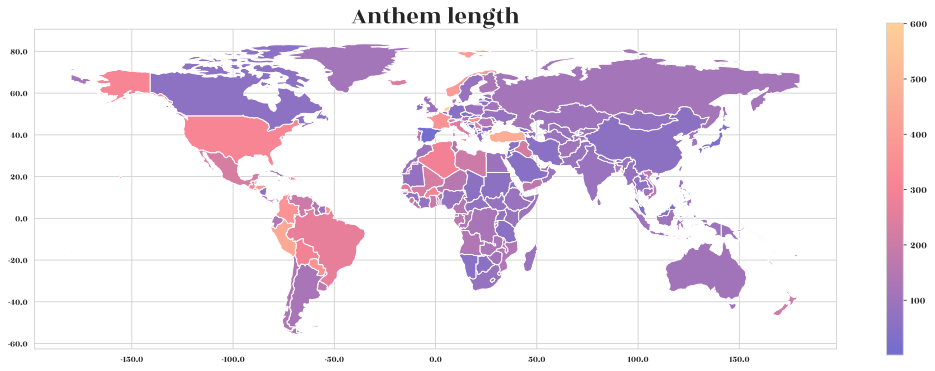

In [52]:
fig, ax = plt.subplots(figsize=(18, 12))
world.plot(ax=ax, column="anthem_length", cmap=cmap, legend=True, legend_kwds={"shrink": 0.5})
ax.set_title("Anthem length", size=24, fontdict=font_dict)
current_x_ticks = ax.get_xticks()
ax.set_xticklabels(current_x_ticks, fontdict=font_dict)
current_y_ticks = ax.get_yticks()
ax.set_yticklabels(current_y_ticks, fontdict=font_dict)
plt.savefig("figures/anthems_length.svg", transparent=True, bbox_inches="tight")

plt.show()

### Mentions of God

In [11]:
world.loc[world["lyrics"].apply(lambda x: "creator" and "god" in x)]

pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
7      8776109.0        Oceania          Papua New Guinea    PNG       24829   
..           ...            ...                       ...    ...         ...   
165   44269594.0         Africa                    Uganda    UGA       35165   
166   12626950.0         Africa                    Rwanda    RWA       10354   
169    6944975.0         Europe                    Serbia    SRB       51475   
172    1394973.0  North America       Trinidad and Tobago    TTO       24269   
173   11062113.0         Africa                  S. Sudan    SSD       11998   

                                              geometry iso_2  \
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    FJ   
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    TZ   
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...    CA   
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...    US   
7    MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...    PG   
..                                                 ...   ...   
165  POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...    UG   
166  POLYGON ((30.41910 -1.13466, 30.81613 -1.69891...    RW   
169  POLYGON ((18.82982 45.90887, 18.82984 45.90888...    RS   
172  POLYGON ((-61.68000 10.76000, -61.10500 10.890...    TT   
173  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...    SS   

                                                lyrics  anthem_length  
0    blessing grant oh god of nations on the isles ...            110  
1    god bless africa bless its leaders let wisdom ...             58  
3    o canada our home and native land true patriot...             63  
4    oh say can you see by the dawns early light wh...            313  
7    o arise all you sons of this land let us sing ...             94  
..                                                 ...            ...  
165  oh uganda may god uphold thee we lay our futur...             73  
166  rwanda our beautiful and dear country adorned ...            173  
169  god of justice thou who saved us when in deepe...            224  
172  forged from the love of liberty in the fires o...             73  
173  oh god we praise and glorify you for your grac...             82  

[61 rows x 9 columns]

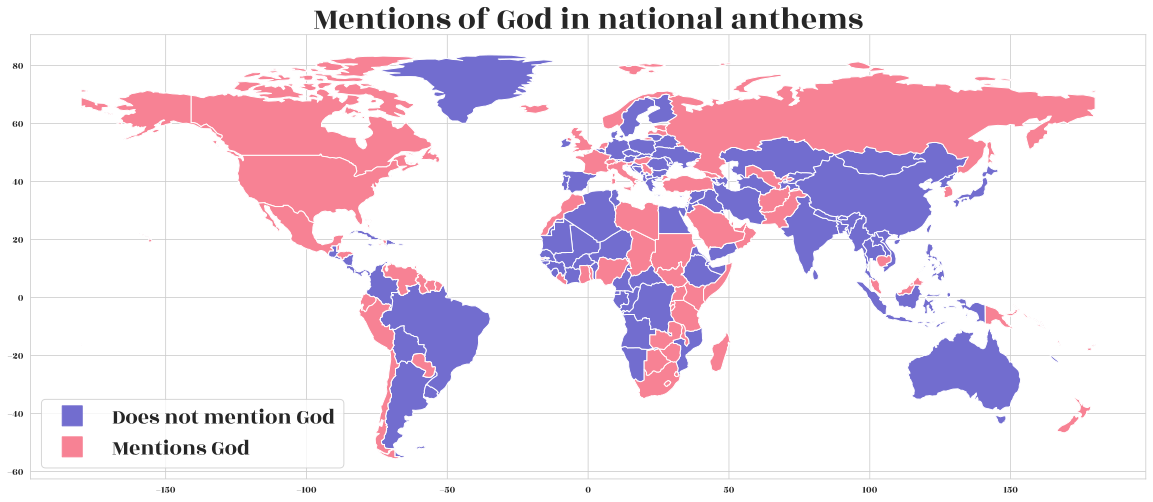

In [16]:
god_anthems = world.loc[world["lyrics"].apply(lambda x: "god" in x)]
lord_anthems = world.loc[world["lyrics"].apply(lambda x: "lord" in x)]
allah_anthems = world.loc[world["lyrics"].apply(lambda x: "allah" in x)]
almightys_anthems = world.loc[world["lyrics"].apply(lambda x: "almightys" in x)]
creator_anthems = world.loc[world["lyrics"].apply(lambda x: "creator" in x)]

fig, ax = plt.subplots(figsize=(20, 12))
# world.plot(ax=ax, color="#F78294")
world.plot(ax=ax, color="#726DCF")
pd.concat([god_anthems, lord_anthems, allah_anthems, almightys_anthems, creator_anthems]).plot(ax=ax, color="#F78294")
lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, ["Does not mention God", "Mentions God"],loc="lower left", fontsize=22)
ax.set_title("Mentions of God in national anthems", size=32)
plt.savefig("figures/mentions_of_god.svg", transparent=True, bbox_inches="tight")
plt.show()

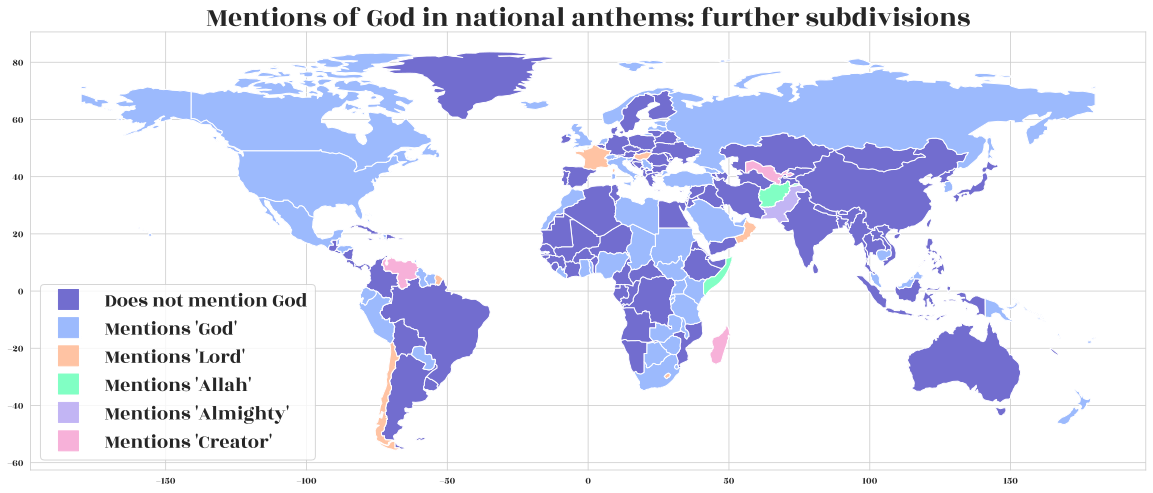

In [18]:
fig, ax = plt.subplots(figsize=(20, 12))
world.plot(ax=ax, color="#726DCF")
god_anthems.plot(ax=ax, color="#9CBAFD", zorder=10)
lord_anthems.plot(ax=ax, color="#FFC3A3")
allah_anthems.plot(ax=ax, color="#81FFC4", zorder=11)
almightys_anthems.plot(ax=ax, color="#C2B5F4")
creator_anthems.plot(ax=ax, color="#F7B1D9")
lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, ["Does not mention God", "Mentions 'God'", 
                  "Mentions 'Lord'", "Mentions 'Allah'", "Mentions 'Almighty'", "Mentions 'Creator'"], 
                  loc="lower left", fontsize=20)
ax.set_title("Mentions of God in national anthems: further subdivisions", size=28)
plt.savefig("figures/mentions_of_god_subdivisions.svg", transparent=True, bbox_inches="tight")
plt.show()

### Military mentions

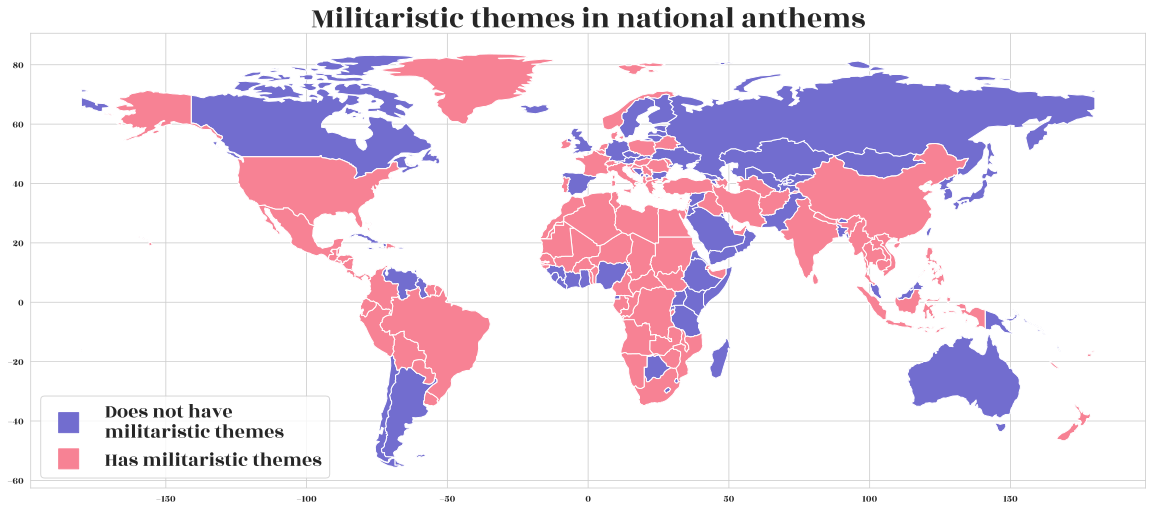

In [65]:
military_list = ["war", "battle_anthems", "army", 
                 "victory", "fight", "conquer", 
                 "blood", "struggle", "sword",
                 "weapon", "gun", "axe", "cannon"]
military_anthems = world.loc[world["lyrics"].apply(lambda x: any(word in x for word in military_list))]

fig, ax = plt.subplots(figsize=(20, 12))
world.plot(ax=ax, color="#726DCF")
military_anthems.plot(ax=ax, color="#F78294") ##81FFC4
lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), 
                markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, ["Does not have\nmilitaristic themes", "Has militaristic themes"], 
          loc="lower left", fontsize=20)
ax.set_title("Militaristic themes in national anthems", size=30)
plt.savefig("figures/militaristic_themes.svg", transparent=True, bbox_inches="tight")
plt.show()

### Flags mentioned

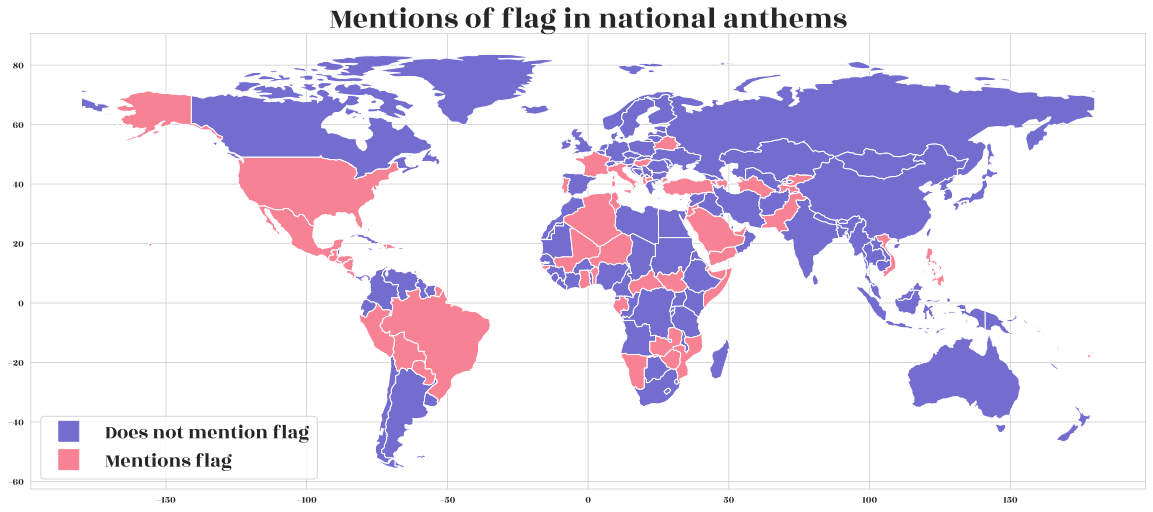

In [13]:
flag_list = ["flag", "banner", "ensign", "pennant", "colors"]
flag_anthems = world.loc[world["lyrics"].apply(lambda x: any(word in x for word in flag_list))]

fig, ax = plt.subplots(figsize=(20, 12))
world.plot(ax=ax, color="#726DCF")
flag_anthems.plot(ax=ax, color="#F78294")
lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), 
                markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, ["Does not mention flag", "Mentions flag"], 
          loc="lower left", fontsize=20)
ax.set_title("Mentions of flag in national anthems", size=30)
plt.savefig("figures/mentions_of_flag.svg", transparent=True, bbox_inches="tight")
plt.show()

### Nature mentioned

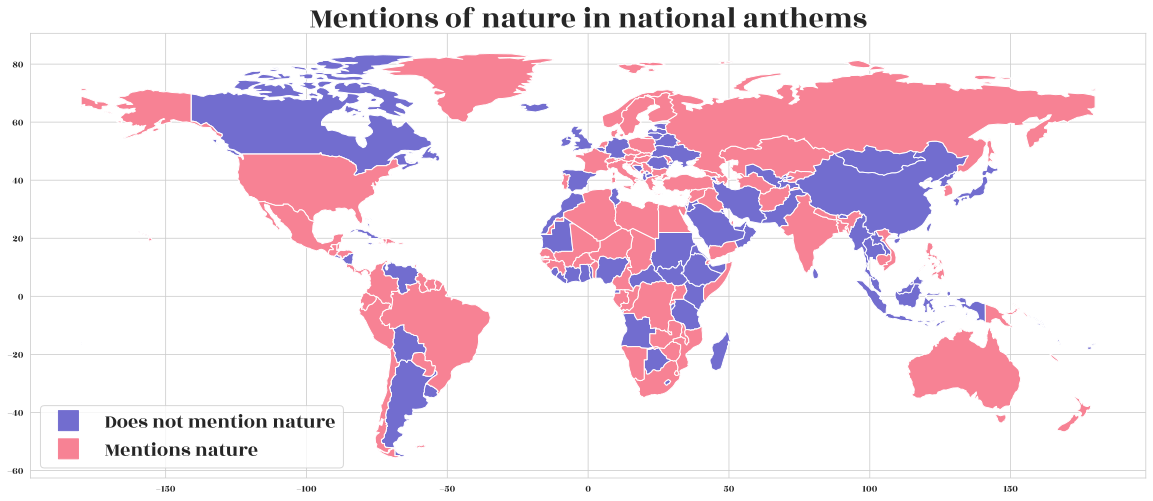

In [14]:
nature_list = ["nature", "forest", "wild", 
               "river", "lake", "earth", 
               "soil", "bird", "eagle",
               "sea", "plain", "field",
               "water", "mountain", "sky", 
               "air"]
nature_anthems = world.loc[world["lyrics"].apply(lambda x: any(word in x for word in nature_list))]

fig, ax = plt.subplots(figsize=(20, 12))
world.plot(ax=ax, color="#726DCF")
nature_anthems.plot(ax=ax, color="#F78294")
lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), 
                markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, ["Does not mention nature", "Mentions nature"], 
          loc="lower left", fontsize=20)
ax.set_title("Mentions of nature in national anthems", size=30)
plt.savefig("figures/mentions_of_nature.svg", transparent=True, bbox_inches="tight")
plt.show()

## N-grams and n-collocations

In [70]:
df.drop(index=df.loc[df["lyrics"] == ""].index.to_list(), inplace=True)

In [71]:
stemmer = SnowballStemmer("english")
stopwords = stopwords.words("english")

def tokenize_and_stem(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens if t not in stopwords]
    return stems

In [72]:
tfidf_vectorizer_lyrics = TfidfVectorizer(max_df=0.95, min_df=0.05, use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_matrix_lyrics = tfidf_vectorizer_lyrics.fit_transform(df["lyrics"])
terms_lyrics = tfidf_vectorizer_lyrics.get_feature_names_out()

c:\Users\Manik\miniconda3\envs\unstructured\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [73]:
def n_gram(n):
    ngram_cv = CountVectorizer(ngram_range=(n,n), max_features = 500, stop_words='english')
    ngram_cv.fit(df["lyrics"])
    ngram_counts = ngram_cv.transform(df["lyrics"]).sum(axis=0).tolist()[0]
    ngram_df = pd.DataFrame({f"{n}-grams": ngram_cv.get_feature_names_out(), "Count": ngram_counts})
    ngram_df.sort_values(by="Count", ascending=False, inplace=True)
    return ngram_df.head(10)

In [74]:
def n_collocation(n):
    if n == 2:
        ngram_finder = BigramCollocationFinder.from_documents(df["lyrics"].apply(lambda x: tokenize_and_stem(x)))
    elif n==3:
        ngram_finder = TrigramCollocationFinder.from_documents(df["lyrics"].apply(lambda x: tokenize_and_stem(x)))
    elif n==4:
        ngram_finder = QuadgramCollocationFinder.from_documents(df["lyrics"].apply(lambda x: tokenize_and_stem(x)))

    ngram_freq = ngram_finder.ngram_fd.items()
    ngram_collocations_df = pd.DataFrame(list(ngram_freq), 
                                columns=[f"{n}-gram", "Count"])
    ngram_collocations_df[f"{n}-gram"] = ngram_collocations_df[f"{n}-gram"].apply(lambda x: " ".join(map(str, x)))
    ngram_collocations_df.sort_values(by="Count", ascending=False, inplace=True)
    
    return ngram_collocations_df.head(10)

In [75]:
n_gram(1)

1-grams  Count
240     land    247
247      let    173
166      god    168
73   country    134
151     free    122
315   people    117
434      thy    109
263     love    104
303       oh     98
164    glory     97

In [76]:
n_gram(2)

2-grams  Count
264          long live     27
161          god bless     23
289        native land     17
197  homeland homeland     13
142          free land     11
147    freedom freedom     11
451     thousand years     11
302             oh god     11
492    witness witness     10
220          land free     10

In [77]:
n_gram(3)

3-grams  Count
283             long life peace      8
208             hail oh liberty      6
480           valour rising let      6
225  homeland homeland homeland      6
230     icelands thousand years      6
347            papua new guinea      6
381             rising let hail      6
270                 let hail oh      6
4         ancient valour rising      6
330              oh god valiant      5

In [78]:
n_gram(4)

4-grams  Count
484           valour rising let hail      6
3          ancient valour rising let      6
265              let hail oh liberty      6
372               rising let hail oh      6
0       algeria live witness witness      5
173             god defend free land      5
174           god defend new zealand      5
272     live witness witness witness      5
83   determined algeria live witness      5
276         love thy paradise nature      4

In [79]:
n_collocation(2)

2-gram  Count
315              let us    127
1042          long live     28
412           god bless     24
682             may god     20
486          nativ land     17
67        thousand year     13
3458  homeland homeland     13
545             give us     12
3904             oh god     11
558     freedom freedom     11

In [80]:
n_collocation(3)

3-gram  Count
11242              long life peac      8
5314                 let us march      8
3075                  let us unit      7
5354                 let us train      7
5337                  let us toil      7
3133          ancient valour rise      6
613                  let us swear      6
5810        iceland thousand year      6
3630   homeland homeland homeland      6
9485             papua new guinea      6

In [81]:
n_collocation(4)

4-gram  Count
3150  ancient valour rise let      6
3152         rise let us hail      6
3153           let us hail oh      6
3151       valour rise let us      6
3154       us hail oh liberti      6
215          live wit wit wit      5
5382          let us toil joy      5
8654     god defend free land      5
5405         let us train son      5
8669   god defend new zealand      5

## Clustering

In [82]:
def plot_internal(X, func, model_name, max_k=11, print=True, **kwargs):
    ks = range(2, max_k)
    results = pd.DataFrame(index=["Silhouette score", "Calinski-Harabasz index", "Davies-Bouldin index"], columns=ks)
    if type(X) is not np.ndarray:
        X = X.toarray()
        
    for k in tqdm(ks, desc=f"Testing {model_name}"):
        model = func(n_clusters=k, **kwargs)
        cluster_labels = model.fit_predict(X)
        results[k] = [silhouette_score(X, cluster_labels), 
                      calinski_harabasz_score(X, cluster_labels),
                      davies_bouldin_score(X, cluster_labels)]
    
    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].plot(ks, results.loc["Silhouette score"].to_list())
    ax[0].scatter(ks, results.loc["Silhouette score"].to_list())
    ax[0].set_xticks(ks)
    ax[0].set_xlabel("k")
    ax[0].set_ylabel("Silhouette score")
    ax[0].set_title("Silhouette score", size=14)
    ax[0].axvline(ks[np.argmax(results.loc["Silhouette score"].to_list())], color="r", linestyle="--", label="maximum", zorder=0)
    ax[0].legend()

    ax[1].plot(ks, results.loc["Calinski-Harabasz index"].to_list())
    ax[1].scatter(ks, results.loc["Calinski-Harabasz index"].to_list())
    ax[1].set_xticks(ks)
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("Calinski-Harabasz index")
    ax[1].set_title("Calinski-Harabasz index", size=14)
    ax[1].axvline(ks[np.argmax(results.loc["Calinski-Harabasz index"].to_list())], color="r", linestyle="--", label="maximum", zorder=0)
    ax[1].legend()

    ax[2].plot(ks, results.loc["Davies-Bouldin index"].to_list())
    ax[2].scatter(ks, results.loc["Davies-Bouldin index"].to_list())
    ax[2].set_xticks(ks)
    ax[2].set_xlabel("k")
    ax[2].set_ylabel("Davies-Bouldin index")
    ax[2].set_title("Davies-Bouldin index", size=14)
    ax[2].axvline(ks[np.argmin(results.loc["Davies-Bouldin index"].to_list())], color="r", linestyle="--", label="minimum", zorder=0)
    ax[2].legend()

    plt.suptitle(f"Internal incides for {model_name} model", size=18)
    plt.tight_layout()
    plt.show()
    
    if print:
        return results

Testing K-Means:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Manik\miniconda3\envs\unstructured\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Testing K-Means:  11%|█         | 1/9 [00:00<00:06,  1.18it/s]c:\Users\Manik\miniconda3\envs\unstructured\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Testing K-Means:  22%|██▏       | 2/9 [00:01<00:05,  1.37it/s]c:\Users\Manik\miniconda3\envs\unstructured\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available

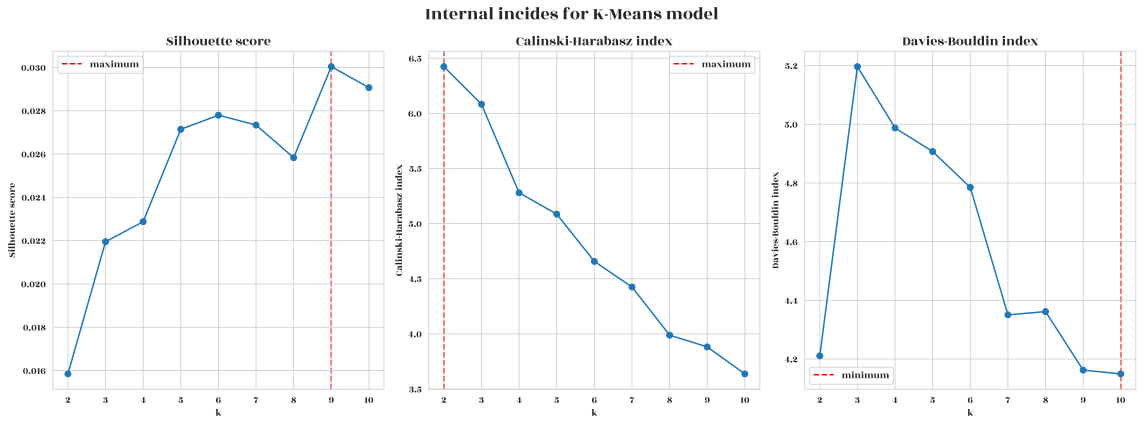

2         3         4         5         6   \
Silhouette score         0.015844  0.021951  0.022878  0.027146  0.027795   
Calinski-Harabasz index  6.423638  6.082452  5.279417  5.085937  4.657139   
Davies-Bouldin index     4.210957  5.196709  4.987613  4.907308  4.784834   

                               7         8         9         10  
Silhouette score         0.027339  0.025830  0.030039  0.029067  
Calinski-Harabasz index  4.425082  3.988448  3.881583  3.636861  
Davies-Bouldin index     4.350637  4.361799  4.162196  4.149351

In [83]:
plot_internal(tfidf_matrix_lyrics, KMeans, "K-Means", **{"init": "k-means++", "n_init": 10, "random_state": 10, "algorithm": "lloyd"})

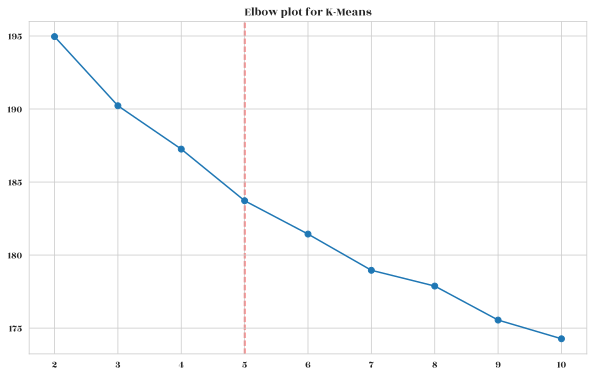

In [84]:
ks = range(2, 11)

inertias1 = []
for k in ks:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=10, algorithm="lloyd")
    kmeans.fit(tfidf_matrix_lyrics)
    inertias1.append(kmeans.inertia_)

from kneed import KneeLocator

knee1 = KneeLocator(ks, inertias1, curve="convex", direction="decreasing")

elbow1 = knee1.elbow
fig, ax = plt.subplots(figsize=(10, 6))

# sns.lineplot(x=ks, y=inertias1, ax=ax)
ax.plot(ks, inertias1)
ax.scatter(ks, inertias1)
ax.axvline(elbow1, ls="--", color="red", zorder=0)
ax.set_title("Elbow plot for K-Means")
ax.set_xticks(ks)

plt.show()

In [85]:
kmeans = KMeans(n_clusters=6, init="k-means++", n_init=10, random_state=10, algorithm="lloyd").fit(tfidf_matrix_lyrics)

In [88]:
# print available fonts
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['C:\\Windows\\Fonts\\trebucbd.ttf',
 'C:\\Users\\Manik\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Meslo LG M Bold Nerd Font Complete Mono.ttf',
 'C:\\Windows\\Fonts\\PAPYRUS.TTF',
 'C:\\Windows\\Fonts\\couri.ttf',
 'C:\\Windows\\Fonts\\WINGDNG2.TTF',
 'C:\\Windows\\Fonts\\javatext.ttf',
 'C:\\Windows\\Fonts\\lucon.ttf',
 'C:\\Windows\\Fonts\\GILI____.TTF',
 'C:\\Windows\\Fonts\\Candaral.ttf',
 'C:\\Windows\\Fonts\\segmdl2.ttf',
 'C:\\Users\\Manik\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Meslo LG M Regular Nerd Font Complete Mono.ttf',
 'C:\\Windows\\Fonts\\COOPBL.TTF',
 'C:\\Windows\\Fonts\\BRUSHSCI.TTF',
 'C:\\Users\\Manik\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Meslo LG S Bold Italic Nerd Font Complete Mono Windows Compatible.ttf',
 'C:\\Windows\\Fonts\\tahoma.ttf',
 'C:\\Windows\\Fonts\\symbol.ttf',
 'C:\\Users\\Manik\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Meslo LG L DZ Italic Nerd Font Complete.ttf',
 'C:\\Windows\\Fonts\\taile.ttf',
 'C:\\Windows\\Fonts\\FRADMCN.TTF'

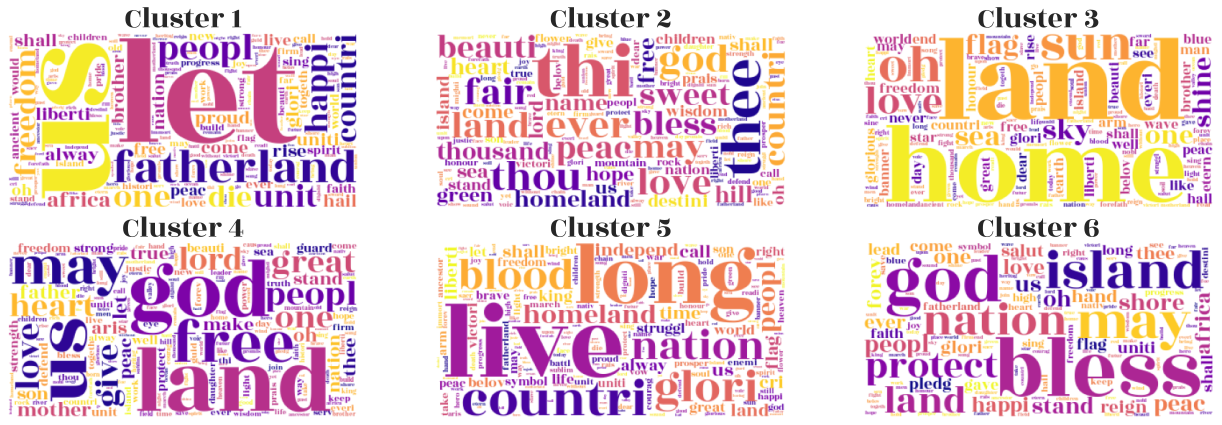

In [89]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = terms_lyrics
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 6))
columns_without_ngrams = [j for j in centroids.columns if " " not in j]

for i in range(centroids.index.stop):
    wc = WordCloud(font_path="C:\\Users\\Manik\\AppData\\Local\\Microsoft\\Windows\\Fonts\\RozhaOne-Regular.ttf", colormap="plasma",background_color="white")
    wc.generate_from_frequencies(centroids.iloc[i][columns_without_ngrams])
    ax[divmod(i, 3)].imshow(wc)
    ax[divmod(i, 3)].axis("off")
    ax[divmod(i, 3)].set_title(f"Cluster {i+1}", size=30)
plt.tight_layout()
plt.savefig("figures/wordclouds.svg", transparent=True, bbox_inches="tight")
plt.show()

In [630]:
df["labels"] = kmeans.labels_

C:\Users\jakub\AppData\Local\Temp\ipykernel_10880\3812447308.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


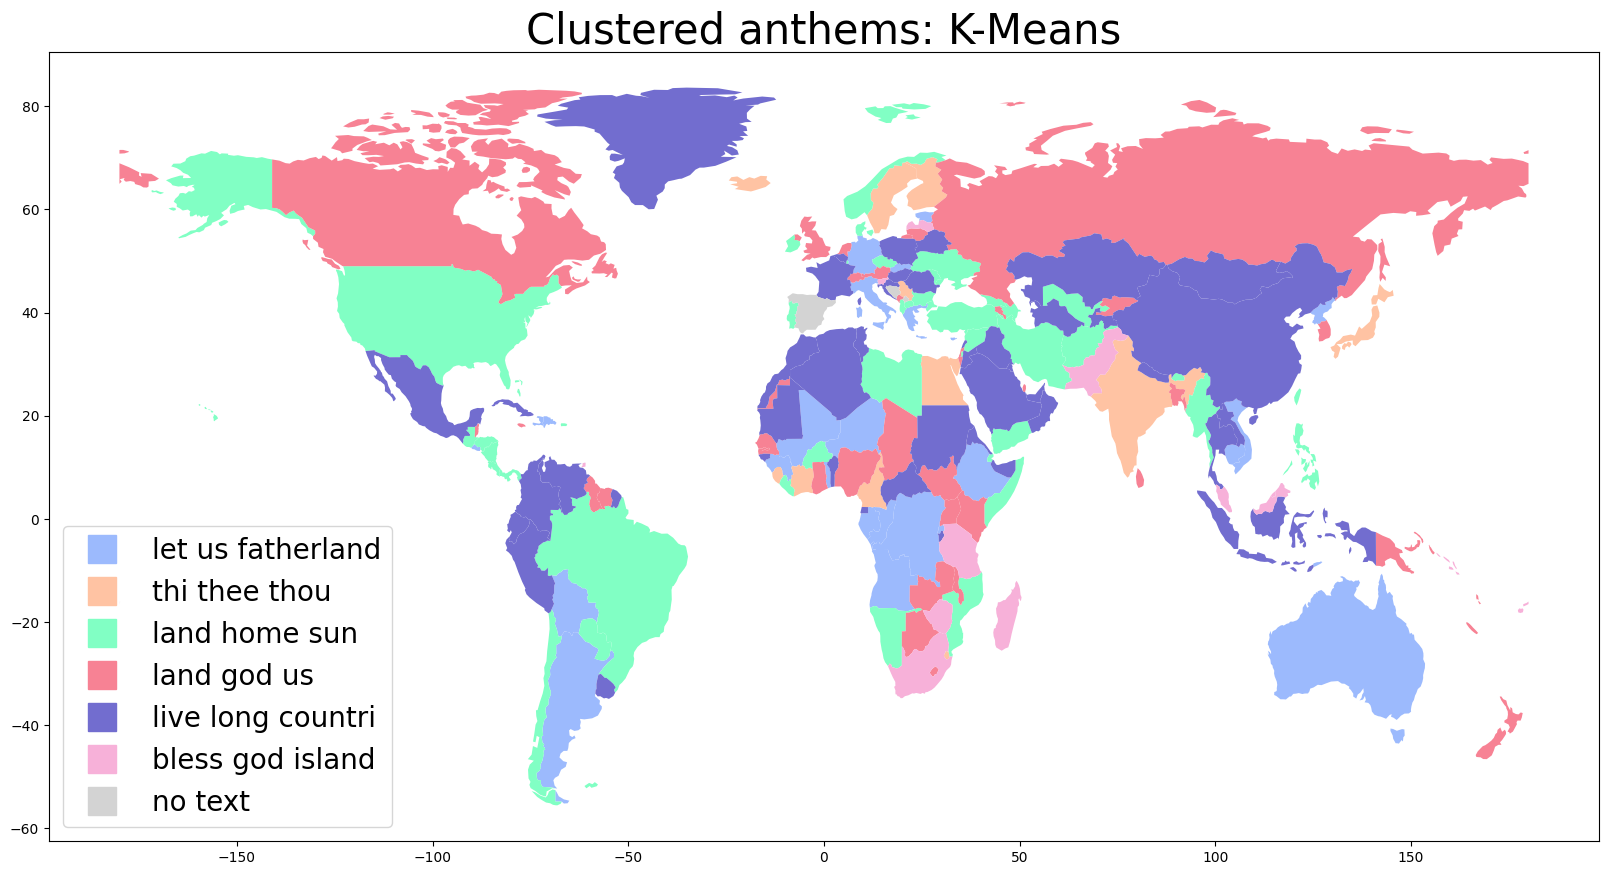

In [631]:
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")
fig, ax = plt.subplots(figsize=(20, 12))

colors = ["#9CBAFD", "#FFC3A3", "#81FFC4", "#F78294", "#726DCF", "#F7B1D9"]

for i in range(kmeans.n_clusters):
    countries = world[world["labels"] == i]
    countries.plot(ax=ax, color=colors[i], legend=True, label=world["labels"])

world_all.loc[world_all["name"].isin(["Kosovo", "Spain", "Bosnia and Herz."])].plot(ax=ax, color="lightgray")

lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, [" ".join(centroids.iloc[i][columns_without_ngrams].sort_values(ascending=False)[:3].index.to_list()) for i in range(kmeans.n_clusters)] + ["no text"],
           loc="lower left", fontsize=20)
ax.set_title("Clustered anthems: K-Means", size=30)
plt.show()

Testing AGNES: 100%|██████████| 9/9 [00:00<00:00, 82.29it/s]


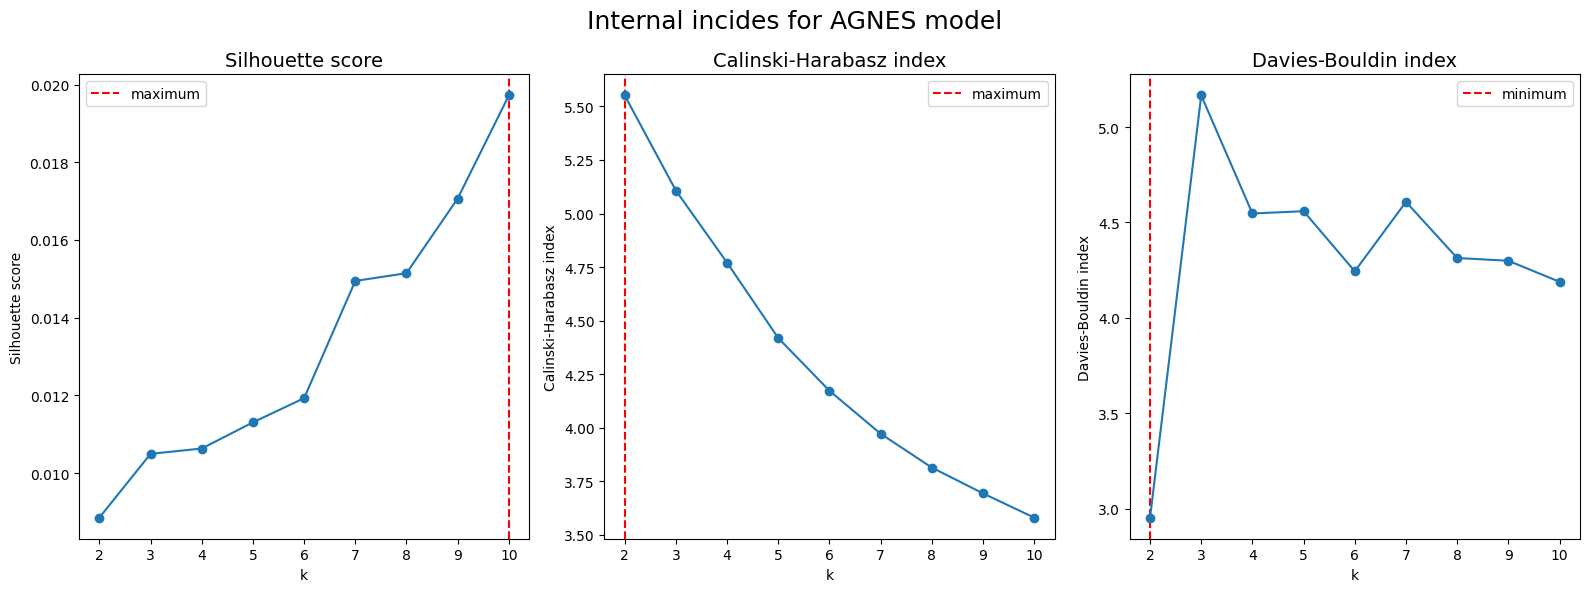

2         3         4         5         6    
Silhouette score         0.008852  0.010494  0.010631  0.011305  0.011927  \
Calinski-Harabasz index  5.551199  5.107080  4.770448  4.418640  4.172745   
Davies-Bouldin index     2.952466  5.165887  4.546983  4.558984  4.244073   

                               7         8         9         10  
Silhouette score         0.014945  0.015145  0.017067  0.019721  
Calinski-Harabasz index  3.971979  3.814017  3.693593  3.580477  
Davies-Bouldin index     4.607834  4.313584  4.299122  4.188865

In [648]:
plot_internal(tfidf_matrix_lyrics, AgglomerativeClustering, "AGNES")

In [649]:
agnes = AgglomerativeClustering(n_clusters=7).fit(tfidf_matrix_lyrics.toarray())

In [650]:
from sklearn.neighbors import NearestCentroid

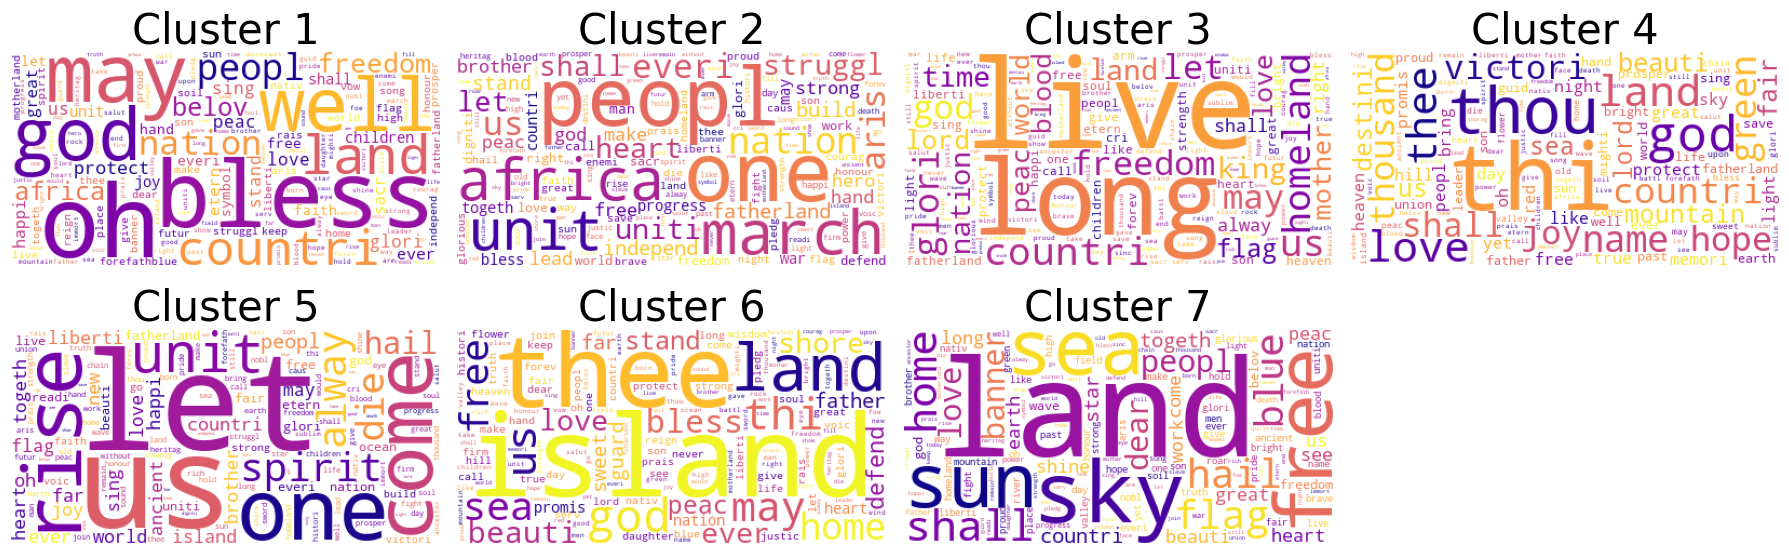

In [651]:
clf = NearestCentroid()
clf.fit(tfidf_matrix_lyrics, agnes.labels_)
clf.centroids_
centroids = pd.DataFrame(clf.centroids_)
centroids.columns = terms_lyrics
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(18, 6))
columns_without_ngrams = [j for j in centroids.columns if " " not in j]

for i in range(centroids.index.stop):
    wc = WordCloud(colormap="plasma",background_color="white")
    wc.generate_from_frequencies(centroids.iloc[i][columns_without_ngrams])
    ax[divmod(i, 4)].imshow(wc)
    ax[divmod(i, 4)].axis("off")
    ax[divmod(i, 4)].set_title(f"Cluster {i+1}", size=30)

fig.delaxes(ax[1, 3])
plt.tight_layout()
plt.show()

In [652]:
df["labels"] = agnes.labels_

C:\Users\jakub\AppData\Local\Temp\ipykernel_10880\663019774.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


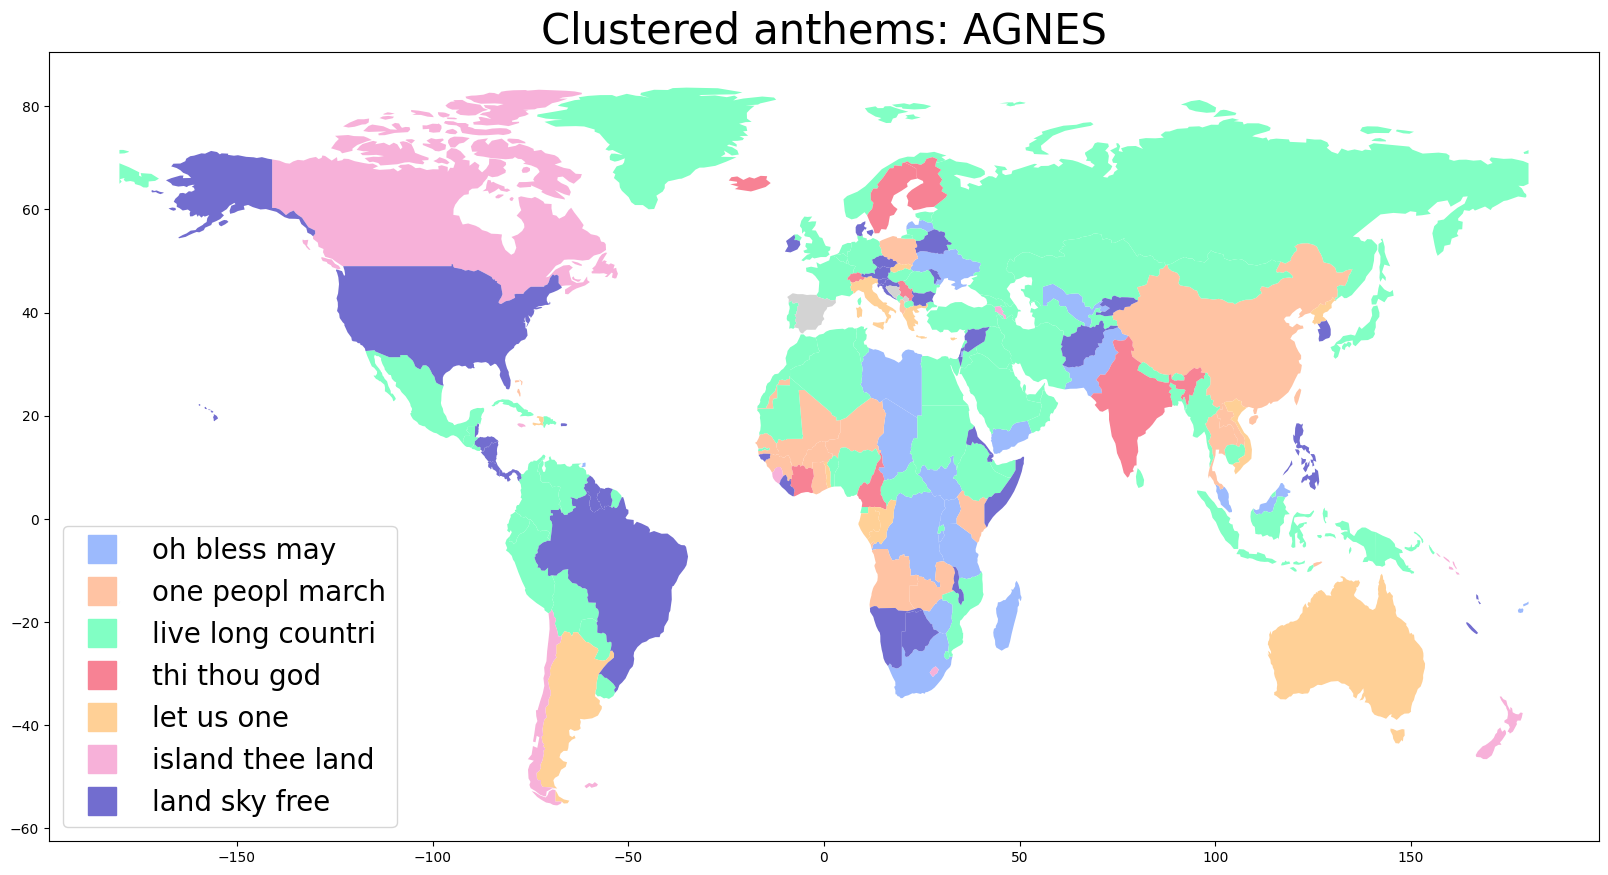

In [653]:
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")
fig, ax = plt.subplots(figsize=(20, 12))

colors = ["#9CBAFD", "#FFC3A3", "#81FFC4", "#F78294", "#FFD096", "#F7B1D9", "#726DCF"]

for i in range(agnes.n_clusters):
    countries = world[world["labels"] == i]
    countries.plot(ax=ax, color=colors[i], legend=True, label=world["labels"])

world_all.loc[world_all["name"].isin(["Kosovo", "Spain", "Bosnia and Herz."])].plot(ax=ax, color="lightgray")

lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, [" ".join(centroids.iloc[i][columns_without_ngrams].sort_values(ascending=False)[:3].index.to_list()) for i in range(agnes.n_clusters)],
           loc="lower left", fontsize=20)
ax.set_title("Clustered anthems: AGNES", size=30)
plt.show()

In [611]:
import umap

In [612]:
comp = umap.UMAP(metric="hellinger", random_state=10).fit_transform(tfidf_matrix_lyrics)

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Testing AGNES: 100%|██████████| 9/9 [00:00<00:00, 124.18it/s]


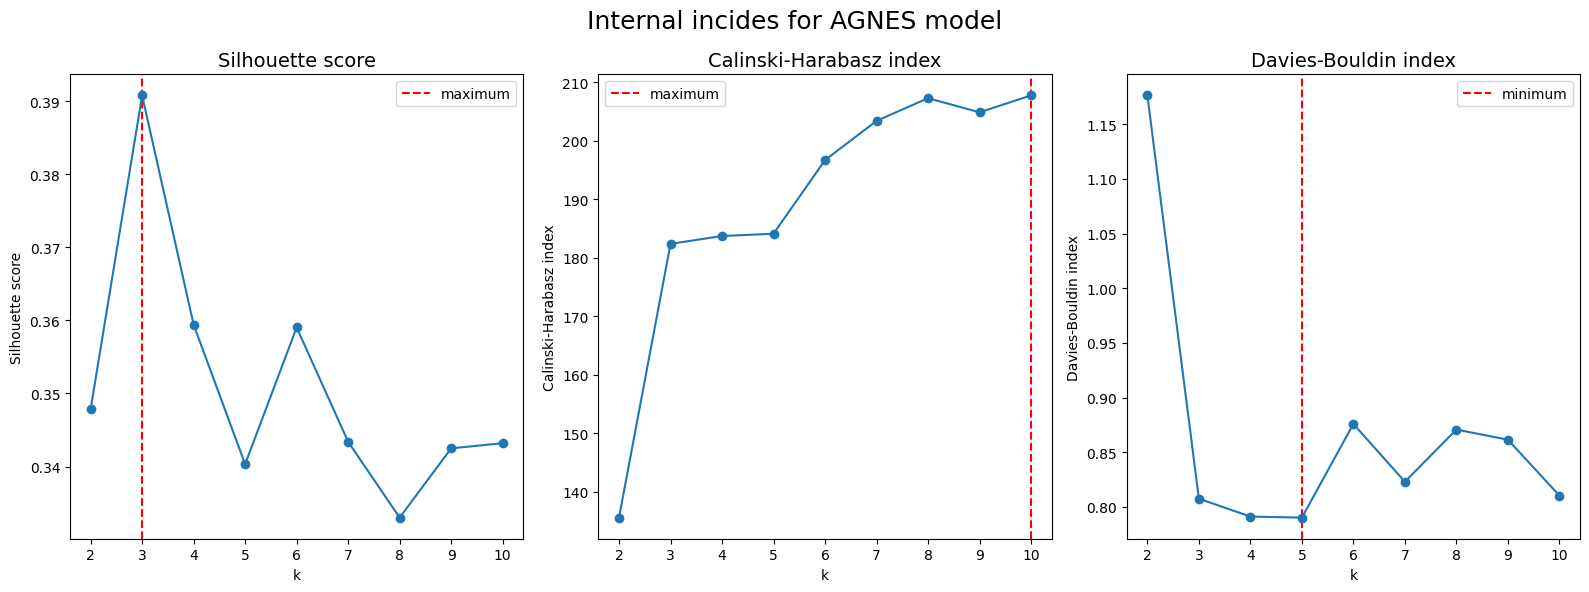

2           3           4           5    
Silhouette score           0.347862    0.390797    0.359419    0.340322  \
Calinski-Harabasz index  135.565038  182.365014  183.710731  184.097149   
Davies-Bouldin index       1.176269    0.807540    0.791221    0.790270   

                                 6           7           8           9    
Silhouette score           0.359042    0.343387    0.333011    0.342486  \
Calinski-Harabasz index  196.687768  203.388397  207.275989  204.859462   
Davies-Bouldin index       0.875881    0.823078    0.870762    0.861495   

                                 10  
Silhouette score           0.343204  
Calinski-Harabasz index  207.742817  
Davies-Bouldin index       0.810429

In [613]:
plot_internal(comp, AgglomerativeClustering, "AGNES")

In [614]:
agnes = AgglomerativeClustering(n_clusters=3).fit(comp)

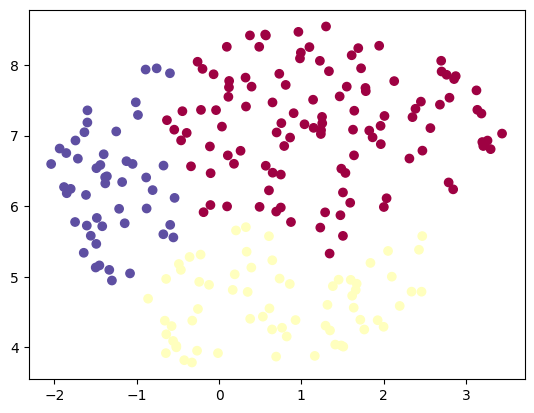

In [615]:
plt.scatter(comp[:,0], comp[:,1], c=agnes.labels_, cmap="Spectral")

In [617]:
df["labels"] = agnes.labels_

C:\Users\jakub\AppData\Local\Temp\ipykernel_10880\2095093114.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


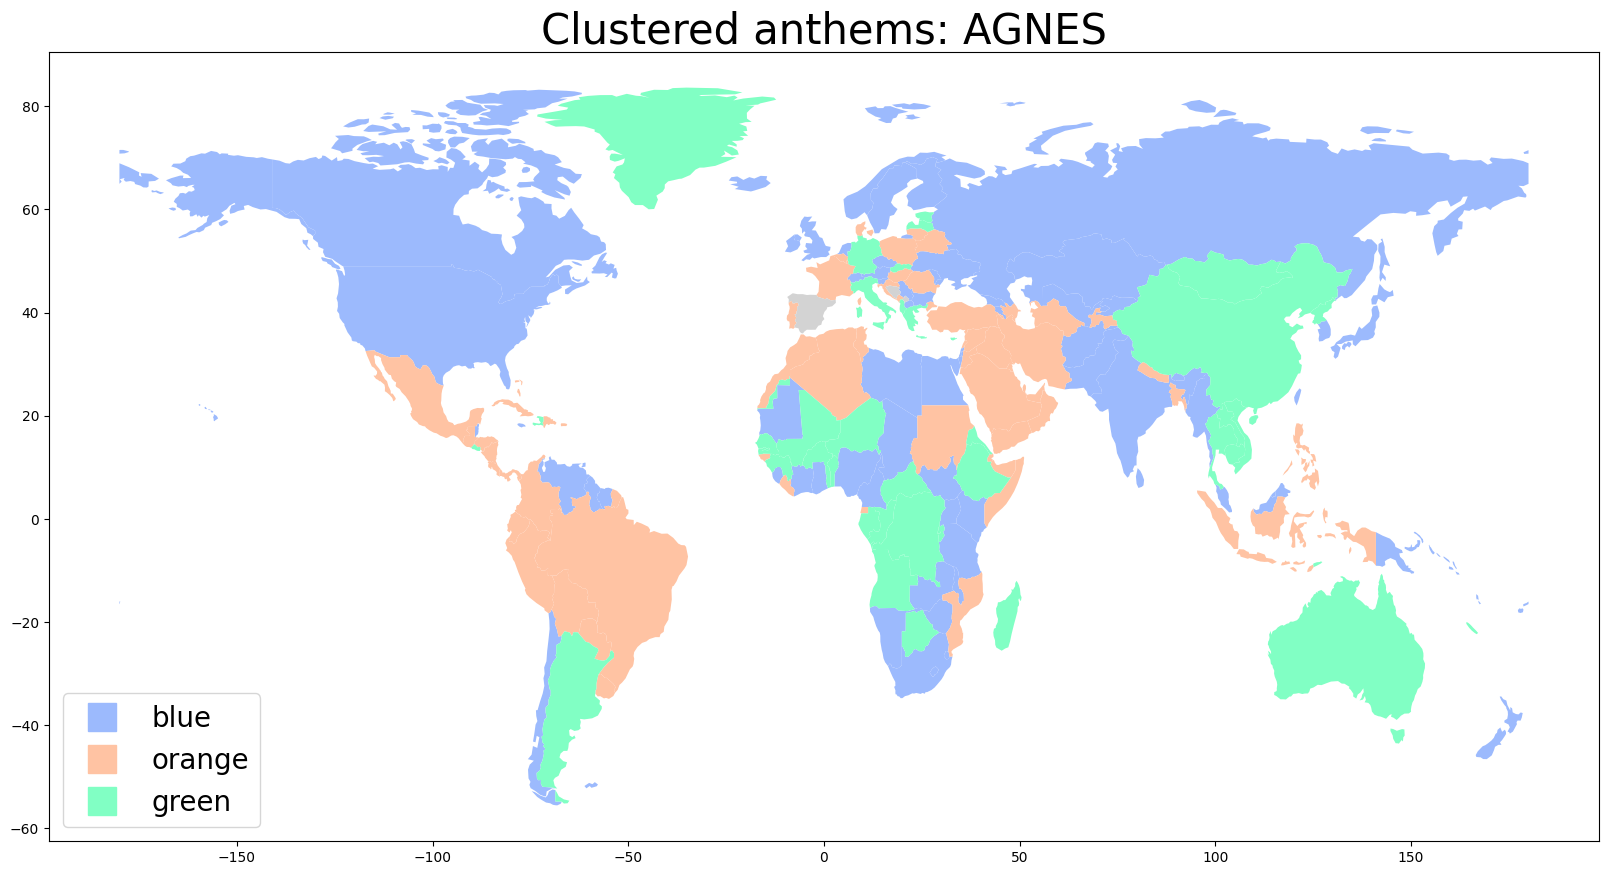

In [623]:
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")
fig, ax = plt.subplots(figsize=(20, 12))

colors = ["#9CBAFD", "#FFC3A3", "#81FFC4", "#F78294", "#FFC3A3", "#F7B1D9", "#726DCF"]

for i in range(agnes.n_clusters):
    countries = world[world["labels"] == i]
    countries.plot(ax=ax, color=colors[i], legend=True, label=world["labels"])

world_all.loc[world_all["name"].isin(["Kosovo", "Spain", "Bosnia and Herz."])].plot(ax=ax, color="lightgray")

lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=20, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.legend(lines, ["blue", "orange", "green"],
           loc="lower left", fontsize=20)
ax.set_title("Clustered anthems: AGNES", size=30)
plt.show()